# Harry Potter and Word2Vec

Word2vec is a method for embedding words into a small latent space which captures semantic meaning. The idea is to use a two layer (one hidden layer) fully connected neural network. The first layer of nodes (representing a one hot encoding of the index of some word $w$) connects to a small hidden layer which then connects to an output layer (representing a one hot encoding of the index of a word that appears near word $w$). Through training, we get the small hidden layer to hold the connection between words and their frequent neighbors.


In this demo, we'll implement word2vec using *Harry Potter and the Sorcerer's Stone* as our text corpus.



## Libraries

As always, we rely on a lot of libraries.

In [1]:
import pandas as pd
import re
import torch
import torch.nn as nn
import numpy as np
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import urllib.request
import numpy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
from google.colab import drive

## Loading Text

We load the text of Harry Potter from a website and preprocess it. In particular, we only want the chapters of the book and we make all words lowercase. Finally, we remove annoying characters like new lines.

In [2]:
url = "https://archive.org/stream/joannek.rowlingharrypotterbook1harrypotterandthephilosophersstoneenglishonlineclub.com/Joanne%20K.%20Rowling%20%28Harry%20Potter%2C%20Book%201%29%20-%20Harry%20Potter%20and%20the%20Philosophers%20Stone%20%5BEnglishOnlineClub.com%5D_djvu.txt"

def read_file(url, start_phrase, end_phrase):
  with urllib.request.urlopen(url) as webpage:
    text = webpage.read().decode("utf8")
    start = text.index(start_phrase)
    text = text[start:]
    end = text.index(end_phrase)
    text = text[:end]
  return text.lower().replace('\n', '').replace('¬','').replace(',','').replace('.','')

text = read_file(url, start_phrase='— CHAPTER ONE — ', end_phrase='J. K.')

## Tokenizing

Now we tokenize the text. That is, we turn the string into a list of words.

In [3]:
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())
  
tokens = tokenize(text)
num_tokens = len(set(tokens))
print(tokens[:100])

['chapter', 'one', 'the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'you', 'd', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didn', 't', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'director', 'of', 'a', 'firm', 'called', 'grunnings', 'which', 'made', 'drills', 'he', 'was', 'a', 'big', 'beefy', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'moustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which']


In [6]:
print(f'There are {len(tokens)} total tokens and {num_tokens} unique tokens.')

There are 81424 total tokens and 5868 unique tokens.


Now we map from each word (token) to a unique index and back. We will use this for the one hot encoding of the word.

In [4]:
def mapping(tokens):
  word_to_id = {}
  id_to_word = {}

  for i, token in enumerate(set(tokens)):
    word_to_id[token] = i
    id_to_word[i] = token
  
  return word_to_id, id_to_word

WORD_TO_ID, ID_TO_WORD = mapping(tokens)
num_tokens = len(set(tokens))

The next step is to get the dataset we will use. We do this by iterating through the tokens with a sliding window. For each word $w$, we look at its neighbors $u$ and add a data point $(w,u)$ where we need to predict $u$ on input $w$. For now, we store the data as indices to avoid carrying around a bunch of zeros in the one hot encoding.

In [5]:
def convert(x):
  return torch.tensor(np.asarray(x)).long()
  
def process(tokens, window=2):
  X, y = [], []
  for i in range(len(tokens)-1):
    for j in list(range(max(0,i-window), min(len(tokens), i+window+1))):
      X += [WORD_TO_ID[tokens[i]]]
      y += [WORD_TO_ID[tokens[j]]]
  return X, y

# Initialization

Now we define the custom class we need so we can wrap the nice DataLoader function around our dataset.

In [6]:
class DataSet(Dataset):
  def __init__(self, tokens):
    X,y = process(tokens)
    self.X = X
    self.y = y
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx] 

dataloader = DataLoader(DataSet(tokens), batch_size = 128, shuffle=True)

In [7]:
class Word2Vec(nn.Module):
  def __init__(self, num_tokens, embed_dim):
    super(Word2Vec, self).__init__()
    self.embedding = nn.Embedding(num_tokens, embed_dim)
    self.linear = nn.Linear(embed_dim, num_tokens)
  
  def forward(self, x):
    embedded = self.embedding(x)
    hidden = self.linear(embedded)
    return F.log_softmax(hidden, dim=1)

Finally, we're ready to initialize the architecture, loss, and optimizer. Notice the simplicity of the model!

In [18]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 64

model = Word2Vec(num_tokens, embed_dim).to(DEVICE)

losses = []

crossentropy = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

Code to interface with google drive for saving and loading model.

In [9]:
#drive.mount('/content/gdrive') # run once
#path = '/content/gdrive/My Drive/embeddings.pth'
#model.load_state_dict(torch.load(path, map_location=DEVICE))

Mounted at /content/gdrive


<All keys matched successfully>

In [19]:
num_epochs = 10

for epoch in range(1, num_epochs+1):
  total_loss = 0
  for (X,y) in dataloader:
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(X)
    loss = crossentropy(outputs, y) 
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  losses += [total_loss/len(dataloader)]
  print(f'Epoch: {epoch} \t Loss: {loss}')


Epoch: 1 	 Loss: 5.619662761688232
Epoch: 2 	 Loss: 5.869677543640137
Epoch: 3 	 Loss: 5.673844337463379
Epoch: 4 	 Loss: 5.8868560791015625
Epoch: 5 	 Loss: 5.078889846801758
Epoch: 6 	 Loss: 4.915075778961182
Epoch: 7 	 Loss: 5.365381240844727
Epoch: 8 	 Loss: 5.304248332977295
Epoch: 9 	 Loss: 5.021874904632568
Epoch: 10 	 Loss: 5.054016590118408


In [11]:
#torch.save(model.state_dict(), path)

## Exploring the Embeddings

What is the next word predicted?

In [20]:
index = 0
words = ['dumbledore']
X = torch.tensor([WORD_TO_ID[word] for word in words]).to(DEVICE)
print('Word:', ID_TO_WORD[X[index].item()])
output = model(X).cpu().detach().numpy()
sorted_indices = np.argsort(output[index])
print('Top 10 related words:')
for i in range(10):
  print(ID_TO_WORD[sorted_indices[i]])

Word: dumbledore
Top 10 related words:
cabbages
whiskery
rotted
barrels
woven
roast
turkeys
golf
riff
bak


To investigate the model, we'll need a measure of similarity and a way of extracting the embedding from the model.

In [21]:
def cosine_similarity(a, b):
  return np.dot(a,b) / (numpy.linalg.norm(a) * numpy.linalg.norm(b))

def embed(word):
  # Remember the embedding is stored in the weights of the first layer
  # We access this by multiplying the input_dim vector by the input_dim x embed_dim matrix
  index = WORD_TO_ID[word]
  return (model.embedding.weight[index]).detach().cpu().numpy()

Let's play around with some words, and visualize the embeddings.

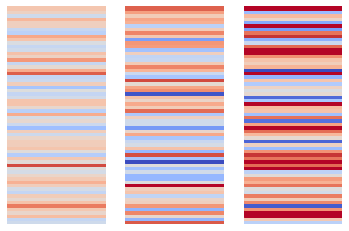

In [22]:
words = ['the', 'wizard']
embeddings = [embed(word) for word in words]
embeddings += [embed('witch')-embed('woman')+embed('man')]
num_embed = len(embeddings)

cmap = matplotlib.cm.coolwarm
fig, axes = plt.subplots(1,num_embed)
norm = matplotlib.colors.Normalize(vmin=embeddings[1].min(), vmax=embeddings[1].max())
for ax, embedding in zip(axes, embeddings):
  for i in range(embed_dim):
    ax.add_patch(Rectangle((0,i/embed_dim),1,.05, color=cmap(norm(embedding[i]))))
  ax.axis('off')
plt.show()

Let's visualize the similarity between words in a matrix.

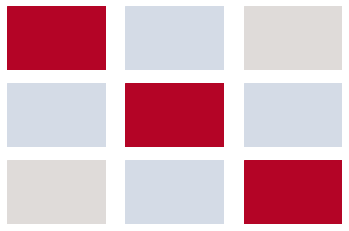

In [23]:
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1) 
fig, axes = plt.subplots(num_embed, num_embed)
for i in range(num_embed):
  for j in range(num_embed):
    ax = axes[i,j]
    similarity = cosine_similarity(embeddings[i], embeddings[j])
    ax.add_patch(Rectangle((0, 0), 1, 1, color=cmap(norm(similarity))))
    ax.axis('off')

Can we classify characters into Gryffindor and Slytherin using their embeddings?

In [24]:
characters = ['harry', 'ron', 'ginny', 'draco', 'severus', 'hagrid', 'neville']
houses = ['gryffindor', 'slytherin']
print('person \t' + '\t'.join(houses))
for character in characters:
  print(character + '\t' + '\t'.join([str(cosine_similarity(embed(house), embed(character))) for house in houses]))

person 	gryffindor	slytherin
harry	0.10376691	-0.05579649
ron	0.045403823	-0.086755104
ginny	0.10809361	0.054500055
draco	0.062133737	0.15266885
severus	-0.04581242	0.10488652
hagrid	0.08648026	-0.019227114
neville	-0.08427258	0.1267893


## GloVe

Another method for embedding words is GloVe proposed in "[GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)". See below for an implementation. Since the method doesn't use a neural network, we manually implement the gradient update.

In [88]:
def process_glove(tokens, window=2):
  X = np.zeros((num_tokens,num_tokens))
  for i in range(len(tokens)):
    for j in list(range(max(0,i-window), min(len(tokens), i+window+1))):
      index_i = WORD_TO_ID[tokens[i]]
      index_j = WORD_TO_ID[tokens[j]]
      weight = 2 if (i-j) == 0 else 1/(i-j)**2
      X[index_i, index_j] += 1
      X[index_j, index_i] += 1
  return X

class GloVe():
  # https://nlp.stanford.edu/pubs/glove.pdf
  def __init__(self, tokens, embed_dim):
    super(GloVe, self).__init__()
    self.X = process_glove(tokens)
    self.W = np.random.normal(size=(2*num_tokens, embed_dim))
    self.b = np.random.normal(size=2*num_tokens)
    # Prevent common pairs from dominating
    self.f = lambda x : (x/100)** (3/4) if x < 100 else 1 
    self.nonzero_row, self.nonzero_col = np.nonzero(self.X)    
  
  def train(self, lr):
    # Cost function is given by
    # Sum_{i,j} f(X[i,j]) * ( w_i^T w_j' + b_i + b_j' - log(X[i,j]) )^2
    total_cost = 0
    for (i,j) in zip(self.nonzero_row, self.nonzero_col):
      main = self.W[i]
      context = self.W[j+num_tokens]
      fX = self.f(self.X[i,j])
      cost = (main @ context + self.b[i+num_tokens] + self.b[j+num_tokens] - np.log(self.X[i,j]))
      # f(X[i,j]) * 
      self.W[i] -= lr * fX * cost * context
      self.W[j+num_tokens] -= lr * fX * cost * main
      self.b[i] -= lr * fX * cost
      self.b[j+num_tokens] -= lr * fX * cost
      total_cost += fX * cost **2
    return total_cost/len(self.nonzero_row)

def train(num_epochs):
  costs = []
  for epoch in range(num_epochs):
    costs += [model.train(lr=.01)]
    print(f'Epoch: {epoch} \t Cost: {costs[-1]}')
  return costs

def embed_glove(word):
  index = WORD_TO_ID[word]
  return model.W[index]

# Most similar words using GloVe
def similar_words_glove(word):
  i = WORD_TO_ID[word]
  similarities = [cosine_similarity(model.W[i], model.W[j+num_tokens]) for j in range(num_tokens)]
  for index in np.argsort(similarities)[:10]:
    print(ID_TO_WORD[index])

#embed_dim = 100
#model = GloVe(tokens, embed_dim=embed_dim)
#costs = train(num_epochs=100)
#similar_words_glove('harry')